### Predicting individual differences from fMRI data

We will use the data from the Consortium for Neuropsychiatric Phenomics ([Poldrack et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5139672/)) to examine prediction of individual differences from fMRI data.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import os
from pathlib import Path
import nilearn
import sklearn
from nilearn.maskers import NiftiMasker
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import RidgeCV, SGDClassifier, SGDRegressor
from scipy.stats import ks_2samp
from nilearn.plotting import plot_stat_map
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import einops
from sklearn.preprocessing import OneHotEncoder

device = 'mps'

### Load the data

In [2]:
basedir = Path('/Users/poldrack/data_unsynced/CNP')
output_dir = basedir / 'output'
if not output_dir.exists():
    output_dir.mkdir()

# load the data
metadata_df = pd.read_csv(basedir / 'ssrt_metadata.csv')
data_img = nib.load(basedir / 'ssrt_cope12_combat.nii.gz')
mask_img = nib.load(basedir / 'ssrt_mask.nii.gz')
masker = NiftiMasker(mask_img)
data = masker.fit_transform(data_img)
assert metadata_df.shape[0] == data.shape[0]

### Continuous prediction is tricky

First let's generate a y variable that we know to be correlated with the fMRI data, and make sure that we can predict it.  We will use a Weibull distribution to generate y values that are slightly skewed, like those in the real data.



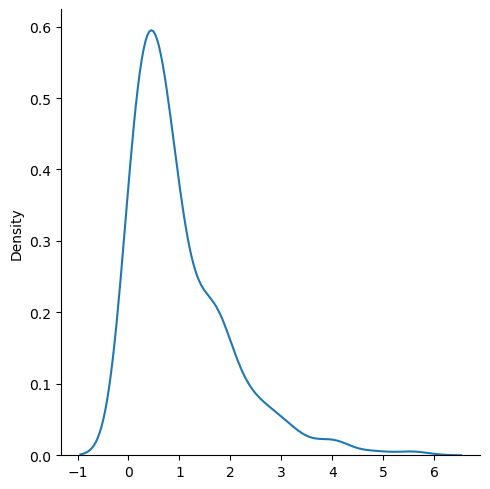

In [73]:
def make_simulated_y(data, snr=0, weib_param=1.1, seed=None):
    rng = np.random.RandomState(seed)
    weights = np.random.randn(data.shape[1])
    y_sim = data.dot(weights) * snr + rng.weibull(weib_param, size=data.shape[0])
    return y_sim

y_sim = make_simulated_y(data, snr=0)
sns.displot(y_sim, kind='kde')


Do ridge regression to see how strong the association is.

In [87]:
def run_ridgeCV(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False,
                clf=None):
    ss = ShuffleSplit(n_splits=nsplits,
                      test_size=test_size, random_state=seed)
    r2 = []
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        train_X = data[train_idx]
        train_y = target[train_idx]
        test_X = data[test_idx]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = RidgeCV
        model = clf()
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        r2.append(sklearn.metrics.r2_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={r2[-1]}')

    return np.mean(r2)

run_ridgeCV(data, y_sim)

np.float64(0.28591053467043887)

Why is the mean r2 negative?

In [88]:

def run_ridgeCV_equaldist(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False, splitmult=10000,
                pthresh=.999, clf=None):
    
    ss = ShuffleSplit(n_splits=nsplits*splitmult,
                      test_size=test_size, random_state=seed)
    r2 = []
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        if ks_2samp(target[train_idx], target[test_idx]).pvalue < pthresh:
            continue
        train_X = data[train_idx]
        train_y = target[train_idx]
        test_X = data[test_idx]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = RidgeCV
        model = clf()
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        r2.append(sklearn.metrics.r2_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={r2[-1]}')
        if len(r2) == nsplits:
            break
    if len(r2) < nsplits:
        print(f'Warning: only {len(r2)} splits completed on {split_idx} attempts')
    else:
        print(f'Completed {len(r2)} splits on {split_idx} attempts')
    return np.mean(r2)

run_ridgeCV_equaldist(data, y_sim)

Completed 100 splits on 94953 attempts


np.float64(0.2938792474471123)

Now generate some data with true signal and make sure it works.

In [77]:
y_sim = make_simulated_y(data, snr=1)
print(run_ridgeCV(data, y_sim))
run_ridgeCV_equaldist(data, y_sim)

0.25632207266547324
Completed 100 splits on 98107 attempts


np.float64(0.286764646229839)

### Decoding continuous behavioral variables across subjects

Let's decode the stop signal reaction time (ssrt) variable.

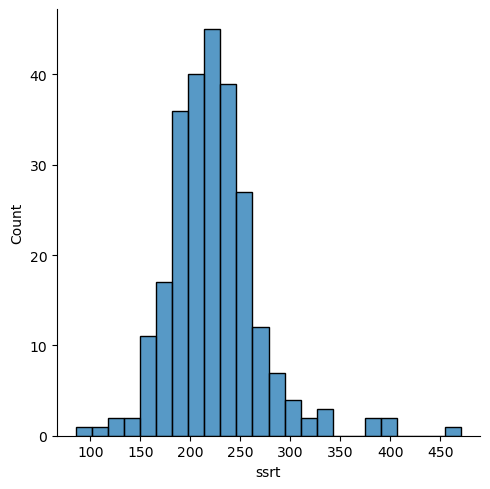

In [3]:
sns.displot(metadata_df['ssrt'])

In [78]:
# use shuffle split

run_ridgeCV_equaldist(data, metadata_df['ssrt'])


Completed 100 splits on 90461 attempts


np.float64(-0.08675965285900208)

### Between-subject classification

patient vs control

In [11]:
metadata_df['patient'] = (metadata_df.diagnosis != 'CONTROL').astype('int')
metadata_df.patient.mean()

np.float64(0.5354330708661418)

Completed 100 splits on 138 attempts
mean accuracy: 0.48668667561496326


Text(0, 0.5, 'accuracy')

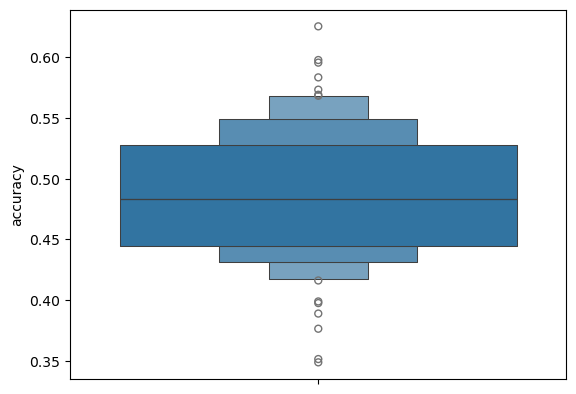

In [126]:
def run_clf_equaldist(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False, splitmult=10000,
                pthresh=.9, clf=None, shuffle_y=False):
    
    ss = ShuffleSplit(n_splits=nsplits*splitmult,
                      test_size=test_size, random_state=seed)
    acc = []
    coefs = None
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        if pthresh is not None and ks_2samp(target[train_idx], target[test_idx]).pvalue < pthresh:
            continue
        if shuffle_y:
            target = np.random.permutation(target)
        train_X = data[train_idx]
        train_y = target[train_idx]
        test_X = data[test_idx]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = SGDClassifier
        model = clf()
        model.fit(train_X, train_y)
        if coefs is None:
            coefs = model.coef_
        else:
            coefs += model.coef_
        pred_y = model.predict(test_X)
        acc.append(sklearn.metrics.balanced_accuracy_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={acc[-1]}')
        if len(acc) == nsplits:
            break
    coefs /= (split_idx + 1)
    if len(acc) < nsplits:
        print(f'Warning: only {len(acc)} splits completed on {split_idx} attempts')
    else:
        print(f'Completed {len(acc)} splits on {split_idx} attempts')
    return acc, coefs

acc, _ = run_clf_equaldist(data, metadata_df.patient)
print(f'mean accuracy: {np.mean(acc)}')
sns.boxenplot(acc)
plt.ylabel('accuracy')


### Predict using a nonlinear model

There may be some nonlinear signals, so let's try a neural network.

In [3]:
# With square kernels and equal stride

n_filters = 8
in_channels = 1
kernel_size = 5
stride = 2
dropout = 0.1
data_shape = np.array(data_img.get_fdata().shape[:3])
out_shape = (data_shape - (kernel_size-1) - 1)//stride + 1
print(out_shape)
print(np.prod(np.concatenate(([n_filters], out_shape))))

layer_stack = torch.nn.ModuleList([])
layer_stack.extend(
        [
            torch.nn.Conv3d(
                in_channels=in_channels,
                out_channels=n_filters,
                kernel_size=kernel_size,
                stride=stride
            ),
            torch.nn.BatchNorm3d(num_features=n_filters),
            torch.nn.ReLU(),
            torch.nn.Dropout3d(p=dropout)
        ]
    )
layer_stack.extend(
    [
        torch.nn.Flatten(),
        torch.nn.Linear(
            in_features=np.prod(out_shape)*n_filters,
            out_features=2
         )
    ])

model = torch.nn.Sequential(*layer_stack)
print(model)
in_data = einops.rearrange(data_img.get_fdata(), 'x y z s -> s 1 x y z')
print(in_data.shape)

i = torch.tensor(in_data).float()
print(i.shape)
output = model(i)

print(output.shape)

[31 37 23]
211048
Sequential(
  (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(2, 2, 2))
  (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout3d(p=0.1, inplace=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=211048, out_features=2, bias=True)
)
(254, 1, 65, 77, 49)
torch.Size([254, 1, 65, 77, 49])
torch.Size([254, 2])


In [4]:
# target shape: np.prod([8, 31, 37, 23]) = np.int64(211048)

data_img.get_fdata().shape[:3]

(65, 77, 49)

In [5]:
print(i.shape)
out_shape = np.array(i.shape[2:])
print(out_shape)
out_shape = (out_shape - (kernel_size-1) - 1)//stride + 1
print(out_shape)
print(np.prod(np.concatenate(([n_filters], out_shape))))
print(np.prod(out_shape)*n_filters)


torch.Size([254, 1, 65, 77, 49])
[65 77 49]
[31 37 23]
211048
211048


In [106]:
from CNNModel import CNNModel

model = CNNModel(
    input_shape=[1],
    out_shape=data_img.get_fdata().shape[:3],
    num_classes=2
)

model.to(device)
print(model)

CNNModel(
  (model): Sequential(
    (0): Conv3d(1, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout3d(p=0.1, inplace=False)
    (4): Conv3d(8, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2))
    (5): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout3d(p=0.1, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=19040, out_features=2, bias=True)
  )
)


In [107]:
def get_dataloaders(train_idx, test_idx, data_img, labels, batch_size=20):
    data = einops.rearrange(data_img.get_fdata(), 'x y z s -> s 1 x y z')
    data_tensor = torch.tensor(in_data.astype('float32')).to(device).to(torch.float32)
    enc = OneHotEncoder(handle_unknown='ignore')
    labels = np.array(labels).reshape(-1, 1)
    labels_tensor = torch.tensor(enc.fit_transform(labels).toarray().astype('float32')).to(device).to(torch.float32)

    Dataset_train = TensorDataset(data_tensor[train_idx], labels_tensor[train_idx])
    Loader_train = DataLoader(Dataset_train, batch_size=batch_size, shuffle=True)

    Dataset_test = TensorDataset(data_tensor[test_idx], labels_tensor[test_idx])
    Loader_test = DataLoader(Dataset_test, batch_size=batch_size, shuffle=True)
    return Loader_train, Loader_test

Loader_train, Loader_test = get_dataloaders([1,2,3], [4,5,6], data_img, metadata_df.patient)



torch.float32

In [108]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    lossvals = []

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        lossvals.append(loss.detach().cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(lossvals)



def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    lossvals = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            lossvals.append(loss.detach().cpu().item())

            #correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return np.mean(lossvals), correct




In [109]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
        model.parameters(),
        lr=.01
    )
nepochs = 3

ss = ShuffleSplit(n_splits=1, test_size=.2, random_state=None)

train_loss = []
test_loss = []
test_correct = []

for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):

    for epoch in range(nepochs):
        Loader_train, Loader_test = get_dataloaders(
            train_idx, test_idx, data_img, metadata_df.patient.values)

        train_loss.append(train_loop(Loader_train, model, loss_fn, optimizer))
        t_loss, t_corr = test_loop(Loader_test, model, loss_fn)
        test_loss.append(t_loss)
        test_correct.append(t_corr)
    


<built-in method type of Tensor object at 0x51878c320>
<built-in method type of Tensor object at 0x51878def0>
<built-in method type of Tensor object at 0x51878e5d0>
<built-in method type of Tensor object at 0x51878f390>
<built-in method type of Tensor object at 0x51878ee40>
<built-in method type of Tensor object at 0x51878fcf0>
<built-in method type of Tensor object at 0x51878f5c0>
<built-in method type of Tensor object at 0x51878ed50>
<built-in method type of Tensor object at 0x51878e760>
<built-in method type of Tensor object at 0x51878f200>
<built-in method type of Tensor object at 0x51882c640>
<built-in method type of Tensor object at 0x51878f390>
<built-in method type of Tensor object at 0x51878c4b0>
<built-in method type of Tensor object at 0x51878c5f0>
<built-in method type of Tensor object at 0x51878ea80>
<built-in method type of Tensor object at 0x51878f5c0>
<built-in method type of Tensor object at 0x51878def0>
<built-in method type of Tensor object at 0x51878ed50>
<built-in 

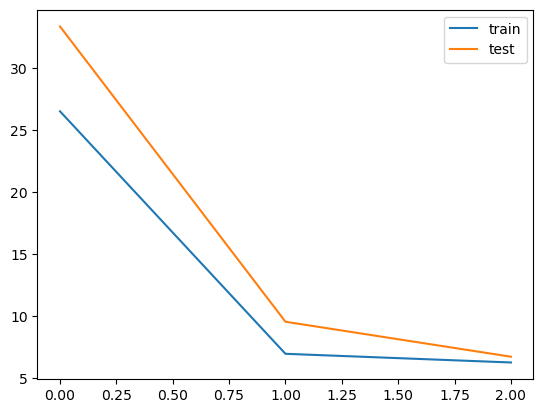

In [111]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])